## 0. Notebook Setup

In [1]:
import pandas as pd
import os


pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

## 1. Load AIDev Dataset

In [2]:
FIG_DIR = "../results/figures"
os.makedirs(FIG_DIR, exist_ok=True)
pull_request      = pd.read_parquet("hf://datasets/hao-li/AIDev/pull_request.parquet")
pr_commit_details = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_commit_details.parquet")

In [4]:
ai_pr = pull_request[pull_request["agent"] != "Human"].copy()
ai_pr["accepted"] = ai_pr["merged_at"].notna().astype(int)
ai_pr = ai_pr.rename(columns={"id": "pr_id"})
ai_pr["desc_length"] = ai_pr["body"].fillna("").astype(str).str.len()

## 2. Compute churn (additions + deletions)

In [5]:
commit_stats = pr_commit_details.groupby("pr_id").agg(
    additions_sum=("additions", "sum"),
    deletions_sum=("deletions", "sum")
).reset_index()

commit_stats["churn"] = commit_stats["additions_sum"] + commit_stats["deletions_sum"]


ai_pr = ai_pr.merge(commit_stats[["pr_id", "churn"]], on="pr_id", how="left")
ai_pr["churn"] = ai_pr["churn"].fillna(0)

## 3. Count number of files changed

In [6]:
files_changed = (
    pr_commit_details.groupby("pr_id")["filename"]
    .nunique()
    .reset_index()
    .rename(columns={"filename": "files_changed"})
)

ai_pr = ai_pr.merge(files_changed, on="pr_id", how="left")
ai_pr["files_changed"] = ai_pr["files_changed"].fillna(0)

## 4. Detect test file presence

In [7]:
test_presence = (
    pr_commit_details.assign(
        is_test=lambda df: df["filename"].str.contains("test", case=False, na=False)
    )
    .groupby("pr_id")["is_test"]
    .max()                
    .reset_index()
)

ai_pr = ai_pr.merge(test_presence, on="pr_id", how="left")
ai_pr["is_test"] = ai_pr["is_test"].fillna(False)

C:\Users\psun6\AppData\Local\Temp\ipykernel_48104\39962892.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ai_pr["is_test"] = ai_pr["is_test"].fillna(False)


## 5. Final cleaned feature table for RQ3

In [8]:
final_features = ai_pr[[
    "pr_id", "agent", "accepted",
    "desc_length", "churn", "files_changed", "is_test"
]]

print(final_features.head())

        pr_id        agent  accepted  desc_length  churn  files_changed  \
0  3264933329  Claude_Code         0         1928  396.0            3.0   
1  3265118634  Claude_Code         1          649   76.0           11.0   
2  3265640341  Claude_Code         1         4516  407.0            5.0   
3  3265709660  Claude_Code         1         2222  300.0           15.0   
4  3265782173  Claude_Code         0          327  221.0           21.0   

   is_test  
0     True  
1     True  
2    False  
3    False  
4     True  


## 6.  matplotlib figure 

C:\Users\psun6\AppData\Local\Temp\ipykernel_48104\2849886906.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
C:\Users\psun6\AppData\Local\Temp\ipykernel_48104\2849886906.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
C:\Users\psun6\AppData\Local\Temp\ipykernel_48104\2849886906.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


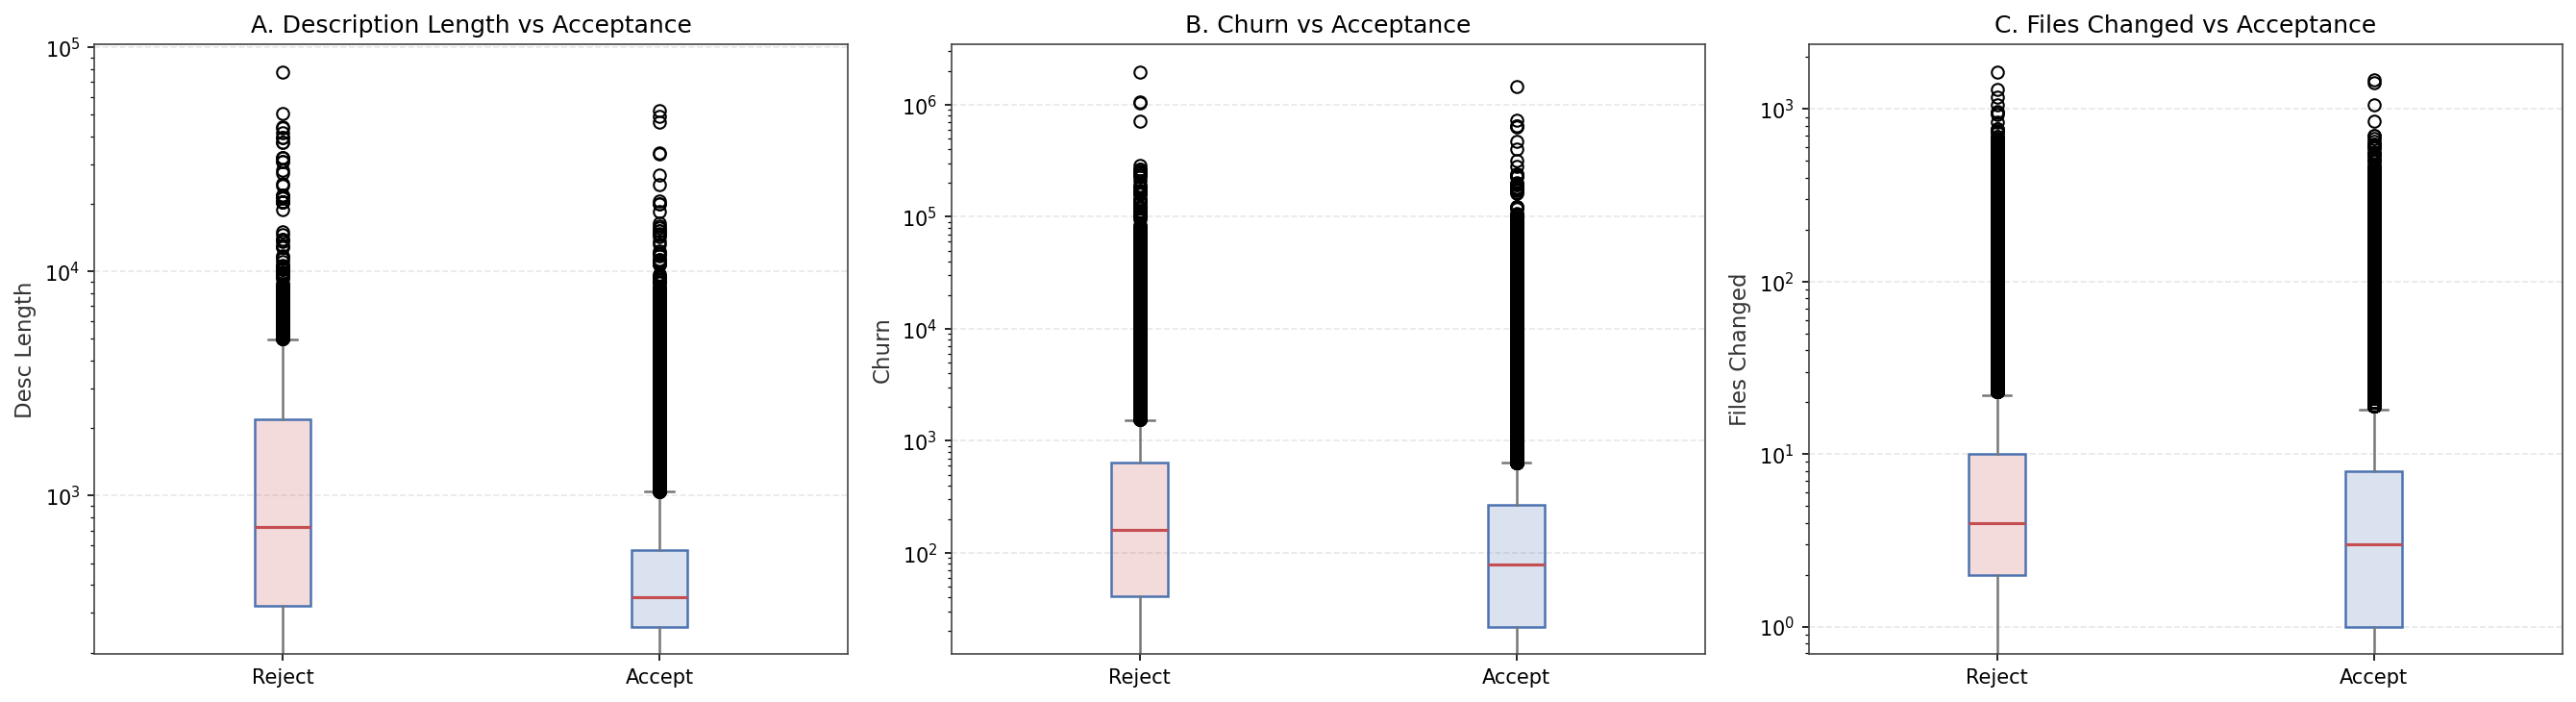

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl


FIG_DIR = "../results/figures"
os.makedirs(FIG_DIR, exist_ok=True)


COLOR_ACCEPT = "#4C72B0"   
COLOR_REJECT = "#C44E52"   
COLOR_BAR     = "#55A868"  

mpl.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.edgecolor": "#444444",
    "axes.labelcolor": "#333333",
    "figure.dpi": 150,
})






def log_boxplot(ax, data, feature, title):
    """
    Create a log-scale boxplot for a numeric feature vs acceptance.
    """
    groups = [
        data[data["accepted"] == 0][feature],
        data[data["accepted"] == 1][feature]
    ]

    bp = ax.boxplot(
        groups,
        patch_artist=True,
        labels=["Reject", "Accept"],
        boxprops=dict(linewidth=1.2, color=COLOR_ACCEPT),
        medianprops=dict(linewidth=1.5, color=COLOR_REJECT),
        whiskerprops=dict(linewidth=1.2, color="#777777"),
        capprops=dict(linewidth=1.2, color="#777777"),
    )

  
    for patch, color in zip(bp["boxes"], [COLOR_REJECT, COLOR_ACCEPT]):
        patch.set_facecolor(color + "33")  # transparency

    ax.set_yscale("log")
    ax.set_title(title)
    ax.set_ylabel(feature.replace("_", " ").title())
    ax.grid(axis="y", linestyle="--", alpha=0.3)




fig, axes = plt.subplots(1, 3, figsize=(18, 5)) 

log_boxplot(
    axes[0],
    final_features,
    "desc_length",
    "A. Description Length vs Acceptance"
)


log_boxplot(
    axes[1],
    final_features,
    "churn",
    "B. Churn vs Acceptance"
)


log_boxplot(
    axes[2],
    final_features,
    "files_changed",
    "C. Files Changed vs Acceptance"
)

plt.tight_layout()


plt.savefig(os.path.join(FIG_DIR, "rq3_fig_summary_features.png"), dpi=300, bbox_inches="tight")

plt.show()
